# Sales Analysis - AAL Australia Apparel (Q4 2020)

**Course-end Project 2 | IIT Khanpur AI/ML Course**

**Project Objective:** Analyze AAL's Q4 2020 sales data across Australian states to identify top-revenue states, understand sales patterns by demographics and time, and provide data-driven recommendations for the upcoming year.

**Dataset:** `AusApparalSales4thQrt2020.csv` — 7,560 records covering daily sales across 7 states, 4 demographic groups, and 3 time periods (Oct–Dec 2020).

---

**Visualization Library Choice: Seaborn**

> We use **Seaborn** as the primary visualization library because:
> - Built on top of Matplotlib with a higher-level interface for statistical graphics
> - Excellent for distribution plots, box plots, and categorical comparisons
> - Integrates seamlessly with Pandas DataFrames
> - Produces publication-quality statistical visualizations with minimal code
> - Ideal for this project since we are performing statistical analysis alongside visualization

## 1. Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
df = pd.read_csv('datasets/AusApparalSales4thQrt2020.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
df.head(10)

Dataset shape: (7560, 6)

Column names: ['Date', 'Time', 'State', 'Group', 'Unit', 'Sales']


,Date,Time,State,Group,Unit,Sales
0,1-Oct-2020,Morning,WA,Kids,8,20000
1,1-Oct-2020,Morning,WA,Men,8,20000
2,1-Oct-2020,Morning,WA,Women,4,10000
3,1-Oct-2020,Morning,WA,Seniors,15,37500
4,1-Oct-2020,Afternoon,WA,Kids,3,7500
5,1-Oct-2020,Afternoon,WA,Men,10,25000
6,1-Oct-2020,Afternoon,WA,Women,3,7500
7,1-Oct-2020,Afternoon,WA,Seniors,11,27500
8,1-Oct-2020,Evening,WA,Kids,15,37500
9,1-Oct-2020,Evening,WA,Men,15,37500


## 2. Data Wrangling

### 2.1 Initial Inspection

In [3]:
# Check data types and basic info
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Date    7560 non-null   str  
 1   Time    7560 non-null   str  
 2   State   7560 non-null   str  
 3   Group   7560 non-null   str  
 4   Unit    7560 non-null   int64
 5   Sales   7560 non-null   int64
dtypes: int64(2), str(4)
memory usage: 566.3 KB


In [4]:
# Check for missing values using isna()
print("Missing values per column (using isna()):")
print(df.isna().sum())
print(f"\nTotal missing values: {df.isna().sum().sum()}")

Missing values per column (using isna()):
Date     0
Time     0
State    0
Group    0
Unit     0
Sales    0
dtype: int64

Total missing values: 0


In [5]:
# Verify no missing values using notna()
print("Non-null counts per column (using notna()):")
print(df.notna().sum())
print(f"\nAll values are present: {df.notna().all().all()}")

Non-null counts per column (using notna()):
Date     7560
Time     7560
State    7560
Group    7560
Unit     7560
Sales    7560
dtype: int64

All values are present: True


**Recommendation on Missing Data Treatment:**

The dataset has **zero missing values**, so no imputation or dropping is required. However, as a general approach:
- If missing values are < 5% of the data, **dropping** them is acceptable
- If missing values are 5–30%, use **imputation** (mean/median for numerical, mode for categorical)
- If missing values are > 30%, consider **dropping the column** entirely

For sales data specifically, **median imputation** is preferred over mean since sales data is often skewed by outliers.

### 2.2 Data Cleaning — Strip Whitespace & Parse Dates

In [6]:
# Strip leading/trailing whitespace from all string columns
str_cols = df.select_dtypes(include='object').columns
for col in str_cols:
    df[col] = df[col].str.strip()

print("Unique values after stripping whitespace:")
print(f"States: {df['State'].unique()}")
print(f"Groups: {df['Group'].unique()}")
print(f"Time:   {df['Time'].unique()}")

Unique values after stripping whitespace:
States: <ArrowStringArray>
['WA', 'NT', 'SA', 'VIC', 'QLD', 'NSW', 'TAS']
Length: 7, dtype: str
Groups: <ArrowStringArray>
['Kids', 'Men', 'Women', 'Seniors']
Length: 4, dtype: str
Time:   <ArrowStringArray>
['Morning', 'Afternoon', 'Evening']
Length: 3, dtype: str


In [7]:
# Parse Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')

# Extract useful date components
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.day_name()
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.month_name()

print("Date parsing complete:")
print(f"Date range: {df['Date'].min().strftime('%d-%b-%Y')} to {df['Date'].max().strftime('%d-%b-%Y')}")
print(f"Months covered: {df['Month_Name'].unique().tolist()}")
df[['Date', 'Day', 'DayOfWeek', 'Week', 'Month', 'Month_Name']].head()

Date parsing complete:
Date range: 01-Oct-2020 to 30-Dec-2020
Months covered: ['October', 'November', 'December']


,Date,Day,DayOfWeek,Week,Month,Month_Name
0,2020-10-01,1,Thursday,40,10,October
1,2020-10-01,1,Thursday,40,10,October
2,2020-10-01,1,Thursday,40,10,October
3,2020-10-01,1,Thursday,40,10,October
4,2020-10-01,1,Thursday,40,10,October


In [8]:
# Check for any incorrect/duplicate entries
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"\nNegative Sales values: {(df['Sales'] < 0).sum()}")
print(f"Negative Unit values: {(df['Unit'] < 0).sum()}")
print(f"Zero Sales values: {(df['Sales'] == 0).sum()}")
print(f"\nData looks clean — no missing, negative, or duplicate entries.")

Duplicate rows: 0

Negative Sales values: 0
Negative Unit values: 0
Zero Sales values: 0

Data looks clean — no missing, negative, or duplicate entries.


### 2.3 Data Normalization

**Why Normalization over Standardization?**

Normalization (Min-Max scaling to [0,1]) is preferred here because:
- Sales data does not follow a normal distribution
- We want to compare relative performance across states/groups on a common scale
- It preserves the shape of the original distribution
- It's more intuitive for business stakeholders (0 = lowest, 1 = highest)

In [9]:
# Min-Max Normalization on Sales and Unit columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Sales_Normalized', 'Unit_Normalized']] = scaler.fit_transform(df[['Sales', 'Unit']])

print("Normalized Sales & Unit columns:")
print(df[['Sales', 'Sales_Normalized', 'Unit', 'Unit_Normalized']].describe())

Normalized Sales & Unit columns:
           Sales  Sales_Normalized     Unit  Unit_Normalized
count   7,560.00          7,560.00 7,560.00         7,560.00
mean   45,013.56              0.25    18.01             0.25
std    32,253.51              0.20    12.90             0.20
min     5,000.00              0.00     2.00             0.00
25%    20,000.00              0.10     8.00             0.10
50%    35,000.00              0.19    14.00             0.19
75%    65,000.00              0.38    26.00             0.38
max   162,500.00              1.00    65.00             1.00


### 2.4 GroupBy Analysis

**Recommendation:** The `GroupBy()` function is best used here for **data chunking** (splitting data into meaningful segments) rather than merging, because:
- We need to analyze sales **by State**, **by Group**, and **by Time** independently
- Chunking allows us to compute aggregate statistics (sum, mean, count) for each segment
- This directly supports the business objective of identifying high/low revenue states and groups

In [10]:
# GroupBy: State-wise aggregation
state_summary = df.groupby('State').agg(
    Total_Sales=('Sales', 'sum'),
    Avg_Sales=('Sales', 'mean'),
    Total_Units=('Unit', 'sum'),
    Transactions=('Sales', 'count')
).sort_values('Total_Sales', ascending=False)

print("State-wise Sales Summary (GroupBy chunking):")
print(state_summary.to_string())

State-wise Sales Summary (GroupBy chunking):
       Total_Sales  Avg_Sales  Total_Units  Transactions
State                                                   
VIC      105565000  97,745.37        42226          1080
NSW       74970000  69,416.67        29988          1080
SA        58857500  54,497.69        23543          1080
QLD       33417500  30,942.13        13367          1080
TAS       22760000  21,074.07         9104          1080
NT        22580000  20,907.41         9032          1080
WA        22152500  20,511.57         8861          1080


In [11]:
# GroupBy: Group-wise aggregation
group_summary = df.groupby('Group').agg(
    Total_Sales=('Sales', 'sum'),
    Avg_Sales=('Sales', 'mean'),
    Total_Units=('Unit', 'sum'),
    Transactions=('Sales', 'count')
).sort_values('Total_Sales', ascending=False)

print("Group-wise Sales Summary:")
print(group_summary.to_string())

Group-wise Sales Summary:
         Total_Sales  Avg_Sales  Total_Units  Transactions
Group                                                     
Men         85750000  45,370.37        34300          1890
Women       85442500  45,207.67        34177          1890
Kids        85072500  45,011.90        34029          1890
Seniors     84037500  44,464.29        33615          1890


In [12]:
# GroupBy: State x Group cross-tabulation (merging/combining chunks)
state_group = df.groupby(['State', 'Group'])['Sales'].sum().unstack(fill_value=0)
print("State x Group Sales Cross-tabulation:")
print(state_group.to_string())

State x Group Sales Cross-tabulation:


Group      Kids       Men   Seniors     Women
State                                        
NSW    18587500  19022500  18187500  19172500
NT      5700000   5762500   5465000   5652500
QLD     8510000   8392500   8190000   8325000
SA     14515000  14655000  14717500  14970000
TAS     5775000   5757500   5650000   5577500
VIC    26360000  26407500  26315000  26482500
WA      5625000   5752500   5512500   5262500


## 3. Data Analysis

### 3.1 Descriptive Statistical Analysis

In [13]:
# Descriptive statistics for Sales column
print("=" * 60)
print("DESCRIPTIVE STATISTICS — SALES COLUMN")
print("=" * 60)
print(f"Mean:               ${df['Sales'].mean():>12,.2f}")
print(f"Median:             ${df['Sales'].median():>12,.2f}")
print(f"Mode:               ${df['Sales'].mode()[0]:>12,.2f}")
print(f"Standard Deviation: ${df['Sales'].std():>12,.2f}")
print(f"Variance:           ${df['Sales'].var():>12,.2f}")
print(f"Skewness:            {df['Sales'].skew():>12.4f}")
print(f"Kurtosis:            {df['Sales'].kurtosis():>12.4f}")
print(f"Min:                ${df['Sales'].min():>12,.2f}")
print(f"Max:                ${df['Sales'].max():>12,.2f}")
print(f"Range:              ${df['Sales'].max() - df['Sales'].min():>12,.2f}")
print(f"IQR:                ${df['Sales'].quantile(0.75) - df['Sales'].quantile(0.25):>12,.2f}")

print()
print("=" * 60)
print("DESCRIPTIVE STATISTICS — UNIT COLUMN")
print("=" * 60)
print(f"Mean:                {df['Unit'].mean():>12.2f}")
print(f"Median:              {df['Unit'].median():>12.2f}")
print(f"Mode:                {df['Unit'].mode()[0]:>12.0f}")
print(f"Standard Deviation:  {df['Unit'].std():>12.2f}")
print(f"Variance:            {df['Unit'].var():>12.2f}")
print(f"Skewness:            {df['Unit'].skew():>12.4f}")
print(f"Kurtosis:            {df['Unit'].kurtosis():>12.4f}")
print(f"Min:                 {df['Unit'].min():>12.0f}")
print(f"Max:                 {df['Unit'].max():>12.0f}")

DESCRIPTIVE STATISTICS — SALES COLUMN
Mean:               $   45,013.56
Median:             $   35,000.00
Mode:               $   22,500.00
Standard Deviation: $   32,253.51
Variance:           $1,040,288,710.18
Skewness:                  1.0856
Kurtosis:                  0.6614
Min:                $    5,000.00
Max:                $  162,500.00
Range:              $  157,500.00
IQR:                $   45,000.00

DESCRIPTIVE STATISTICS — UNIT COLUMN
Mean:                       18.01
Median:                     14.00
Mode:                           9
Standard Deviation:         12.90
Variance:                  166.45
Skewness:                  1.0856
Kurtosis:                  0.6614
Min:                            2
Max:                           65


### 3.2 Box Plots for Descriptive Statistics

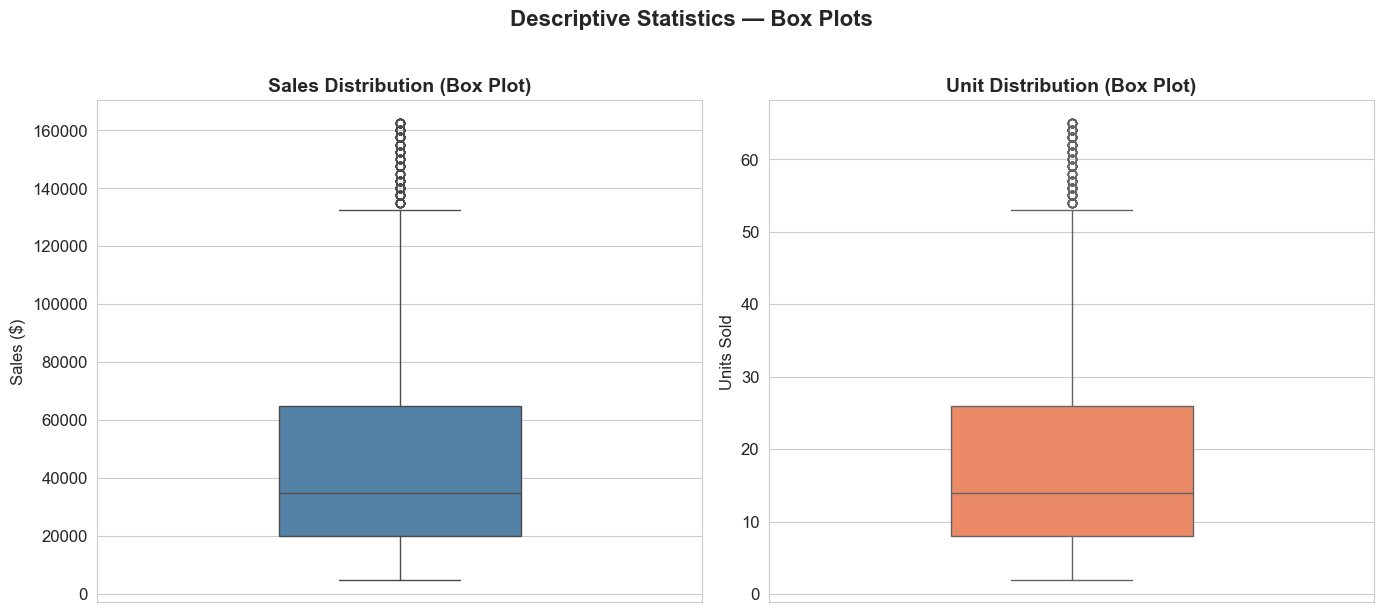

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for Sales
sns.boxplot(y=df['Sales'], ax=axes[0], color='steelblue', width=0.4)
axes[0].set_title('Sales Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sales ($)')

# Box plot for Units
sns.boxplot(y=df['Unit'], ax=axes[1], color='coral', width=0.4)
axes[1].set_title('Unit Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Units Sold')

plt.suptitle('Descriptive Statistics — Box Plots', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.3 Distribution Plots (Seaborn)

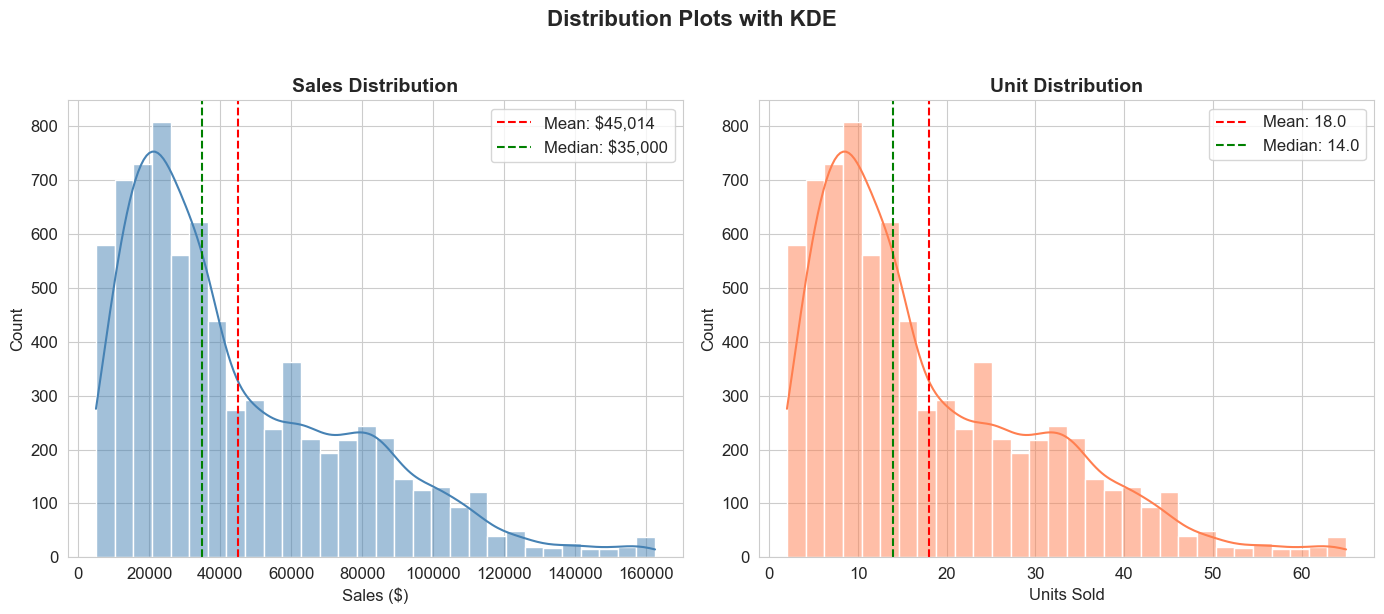

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution plot for Sales
sns.histplot(df['Sales'], kde=True, ax=axes[0], color='steelblue', bins=30)
axes[0].axvline(df['Sales'].mean(), color='red', linestyle='--', label=f"Mean: ${df['Sales'].mean():,.0f}")
axes[0].axvline(df['Sales'].median(), color='green', linestyle='--', label=f"Median: ${df['Sales'].median():,.0f}")
axes[0].set_title('Sales Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sales ($)')
axes[0].legend()

# Distribution plot for Units
sns.histplot(df['Unit'], kde=True, ax=axes[1], color='coral', bins=30)
axes[1].axvline(df['Unit'].mean(), color='red', linestyle='--', label=f"Mean: {df['Unit'].mean():.1f}")
axes[1].axvline(df['Unit'].median(), color='green', linestyle='--', label=f"Median: {df['Unit'].median():.1f}")
axes[1].set_title('Unit Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Units Sold')
axes[1].legend()

plt.suptitle('Distribution Plots with KDE', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.4 Highest & Lowest Sales by Group

Group-wise Total Sales:
         Men: $  85,750,000
       Women: $  85,442,500
        Kids: $  85,072,500
     Seniors: $  84,037,500

✓ Highest Sales Group: Men ($85,750,000)
✗ Lowest Sales Group:  Seniors ($84,037,500)


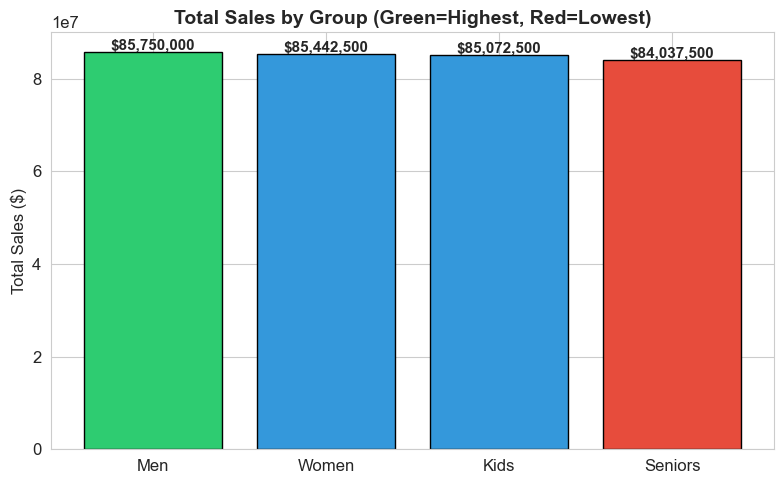

In [16]:
group_sales = df.groupby('Group')['Sales'].sum().sort_values(ascending=False)

print("Group-wise Total Sales:")
for group, sales in group_sales.items():
    print(f"  {group:>10s}: ${sales:>12,.0f}")

print(f"\n✓ Highest Sales Group: {group_sales.idxmax()} (${group_sales.max():,.0f})")
print(f"✗ Lowest Sales Group:  {group_sales.idxmin()} (${group_sales.min():,.0f})")

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71' if g == group_sales.idxmax() else '#e74c3c' if g == group_sales.idxmin() else '#3498db'
          for g in group_sales.index]
bars = ax.bar(group_sales.index, group_sales.values, color=colors, edgecolor='black')
for bar, val in zip(bars, group_sales.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500000,
            f'${val:,.0f}', ha='center', fontweight='bold', fontsize=11)
ax.set_ylabel('Total Sales ($)')
ax.set_title('Total Sales by Group (Green=Highest, Red=Lowest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.5 Highest & Lowest Sales by State

State-wise Total Sales:
    VIC: $ 105,565,000
    NSW: $  74,970,000
     SA: $  58,857,500
    QLD: $  33,417,500
    TAS: $  22,760,000
     NT: $  22,580,000
     WA: $  22,152,500

✓ Highest Revenue State: VIC ($105,565,000)
✗ Lowest Revenue State:  WA ($22,152,500)


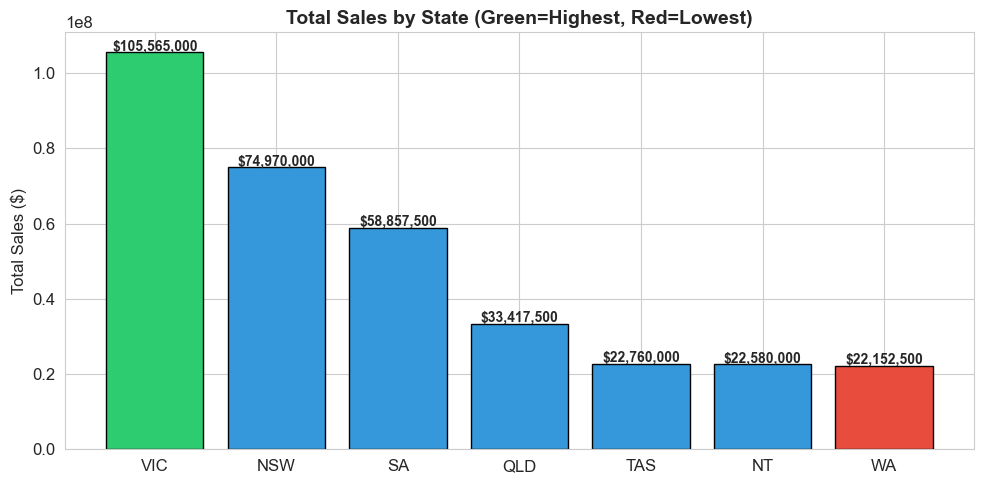

In [17]:
state_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=False)

print("State-wise Total Sales:")
for state, sales in state_sales.items():
    print(f"  {state:>5s}: ${sales:>12,.0f}")

print(f"\n✓ Highest Revenue State: {state_sales.idxmax()} (${state_sales.max():,.0f})")
print(f"✗ Lowest Revenue State:  {state_sales.idxmin()} (${state_sales.min():,.0f})")

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2ecc71' if s == state_sales.idxmax() else '#e74c3c' if s == state_sales.idxmin() else '#3498db'
          for s in state_sales.index]
bars = ax.bar(state_sales.index, state_sales.values, color=colors, edgecolor='black')
for bar, val in zip(bars, state_sales.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500000,
            f'${val:,.0f}', ha='center', fontweight='bold', fontsize=10)
ax.set_ylabel('Total Sales ($)')
ax.set_title('Total Sales by State (Green=Highest, Red=Lowest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.6 Weekly Sales Report

Weekly Sales Report (Q4 2020):
 Week  Total_Sales  Avg_Sales  Total_Units  Transactions
   40     15045000  44,776.79         6018           336
   41     27002500  45,922.62        10801           588
   42     26640000  45,306.12        10656           588
   43     26815000  45,603.74        10726           588
   44     21807500  43,268.85         8723           504
   45     20865000  35,484.69         8346           588
   46     21172500  36,007.65         8469           588
   47     21112500  35,905.61         8445           588
   48     21477500  36,526.36         8591           588
   49     29622500  50,378.40        11849           588
   50     31525000  53,613.95        12610           588
   51     31655000  53,835.03        12662           588
   52     31770000  54,030.61        12708           588
   53     13792500  54,732.14         5517           252


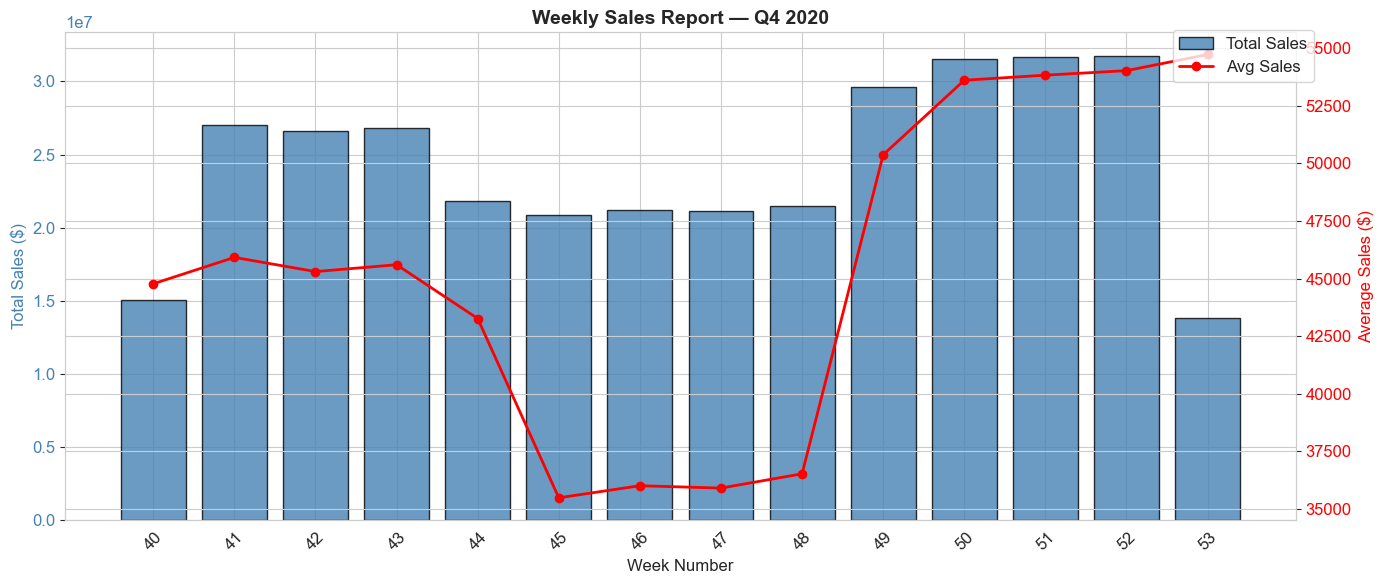

In [18]:
weekly_report = df.groupby('Week').agg(
    Total_Sales=('Sales', 'sum'),
    Avg_Sales=('Sales', 'mean'),
    Total_Units=('Unit', 'sum'),
    Transactions=('Sales', 'count')
).reset_index()

print("Weekly Sales Report (Q4 2020):")
print(weekly_report.to_string(index=False))

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.bar(weekly_report['Week'].astype(str), weekly_report['Total_Sales'], color='steelblue',
        edgecolor='black', alpha=0.8, label='Total Sales')
ax1.set_xlabel('Week Number')
ax1.set_ylabel('Total Sales ($)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(weekly_report['Week'].astype(str), weekly_report['Avg_Sales'], color='red',
         marker='o', linewidth=2, label='Avg Sales')
ax2.set_ylabel('Average Sales ($)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Weekly Sales Report — Q4 2020', fontsize=14, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))
plt.tight_layout()
plt.show()

### 3.7 Monthly Sales Report

Monthly Sales Report (Q4 2020):
Month_Name  Total_Sales  Avg_Sales  Total_Units  Transactions
   October    114290000  45,353.17        45716          2520
  November     90682500  35,985.12        36273          2520
  December    135330000  53,702.38        54132          2520


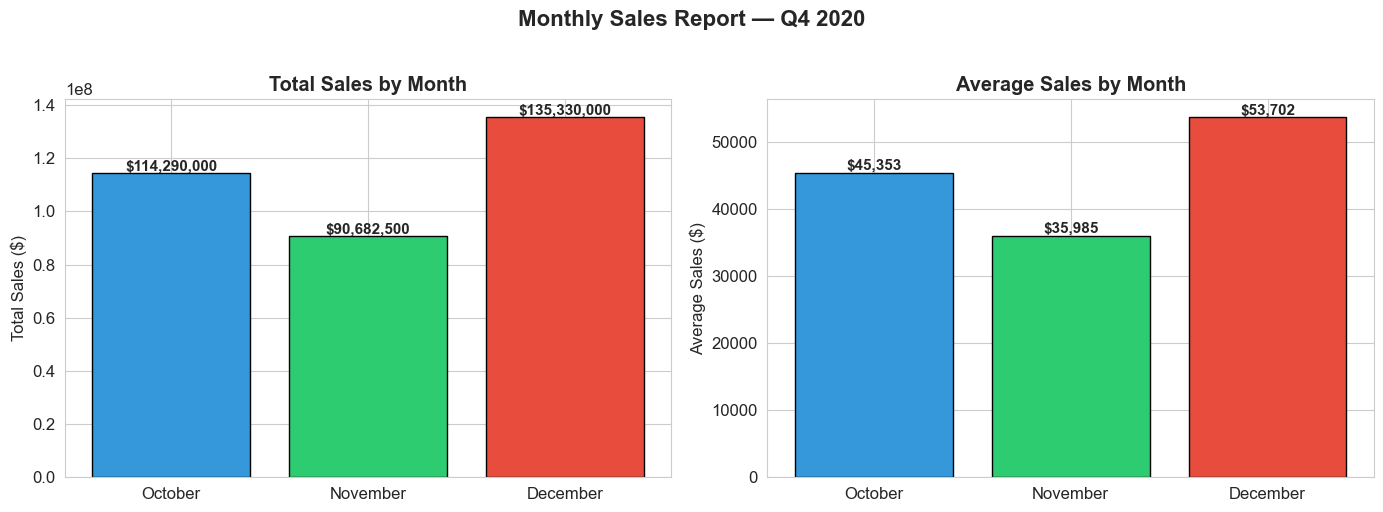

In [19]:
monthly_report = df.groupby(['Month', 'Month_Name']).agg(
    Total_Sales=('Sales', 'sum'),
    Avg_Sales=('Sales', 'mean'),
    Total_Units=('Unit', 'sum'),
    Transactions=('Sales', 'count')
).reset_index()

print("Monthly Sales Report (Q4 2020):")
print(monthly_report[['Month_Name', 'Total_Sales', 'Avg_Sales', 'Total_Units', 'Transactions']].to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total Sales by Month
axes[0].bar(monthly_report['Month_Name'], monthly_report['Total_Sales'],
            color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black')
for i, (_, row) in enumerate(monthly_report.iterrows()):
    axes[0].text(i, row['Total_Sales'] + 1000000, f"${row['Total_Sales']:,.0f}",
                 ha='center', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Total Sales ($)')
axes[0].set_title('Total Sales by Month', fontweight='bold')

# Average Sales by Month
axes[1].bar(monthly_report['Month_Name'], monthly_report['Avg_Sales'],
            color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black')
for i, (_, row) in enumerate(monthly_report.iterrows()):
    axes[1].text(i, row['Avg_Sales'] + 500, f"${row['Avg_Sales']:,.0f}",
                 ha='center', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Average Sales ($)')
axes[1].set_title('Average Sales by Month', fontweight='bold')

plt.suptitle('Monthly Sales Report — Q4 2020', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.8 Quarterly Sales Report

In [20]:
print("=" * 60)
print("QUARTERLY SALES REPORT -- Q4 2020")
print("=" * 60)
print(f"Total Sales:          ${df['Sales'].sum():>14,.0f}")
print(f"Average Sales/Txn:    ${df['Sales'].mean():>14,.2f}")
print(f"Median Sales/Txn:     ${df['Sales'].median():>14,.2f}")
print(f"Std Dev of Sales:     ${df['Sales'].std():>14,.2f}")
print(f"Total Units Sold:      {df['Unit'].sum():>14,.0f}")
print(f"Avg Units/Txn:         {df['Unit'].mean():>14.2f}")
print(f"Total Transactions:    {len(df):>14,.0f}")
print("=" * 60)

# Quarterly breakdown by State and Group
print("\nQuarterly Sales by State:")
print(df.groupby('State')['Sales'].agg(['sum', 'mean', 'count']).rename(
    columns={'sum': 'Total_Sales', 'mean': 'Avg_Sales', 'count': 'Transactions'}
).sort_values('Total_Sales', ascending=False).to_string())

print("\nQuarterly Sales by Group:")
print(df.groupby('Group')['Sales'].agg(['sum', 'mean', 'count']).rename(
    columns={'sum': 'Total_Sales', 'mean': 'Avg_Sales', 'count': 'Transactions'}
).sort_values('Total_Sales', ascending=False).to_string())

QUARTERLY SALES REPORT -- Q4 2020
Total Sales:          $   340,302,500
Average Sales/Txn:    $     45,013.56
Median Sales/Txn:     $     35,000.00
Std Dev of Sales:     $     32,253.51
Total Units Sold:             136,121
Avg Units/Txn:                  18.01
Total Transactions:             7,560

Quarterly Sales by State:
       Total_Sales  Avg_Sales  Transactions
State                                      
VIC      105565000  97,745.37          1080
NSW       74970000  69,416.67          1080
SA        58857500  54,497.69          1080
QLD       33417500  30,942.13          1080
TAS       22760000  21,074.07          1080
NT        22580000  20,907.41          1080
WA        22152500  20,511.57          1080

Quarterly Sales by Group:
         Total_Sales  Avg_Sales  Transactions
Group                                        
Men         85750000  45,370.37          1890
Women       85442500  45,207.67          1890
Kids        85072500  45,011.90          1890
Seniors     84037500

## 4. Data Visualization — Sales Dashboard

### 4.1 State-wise Sales Analysis by Demographic Group

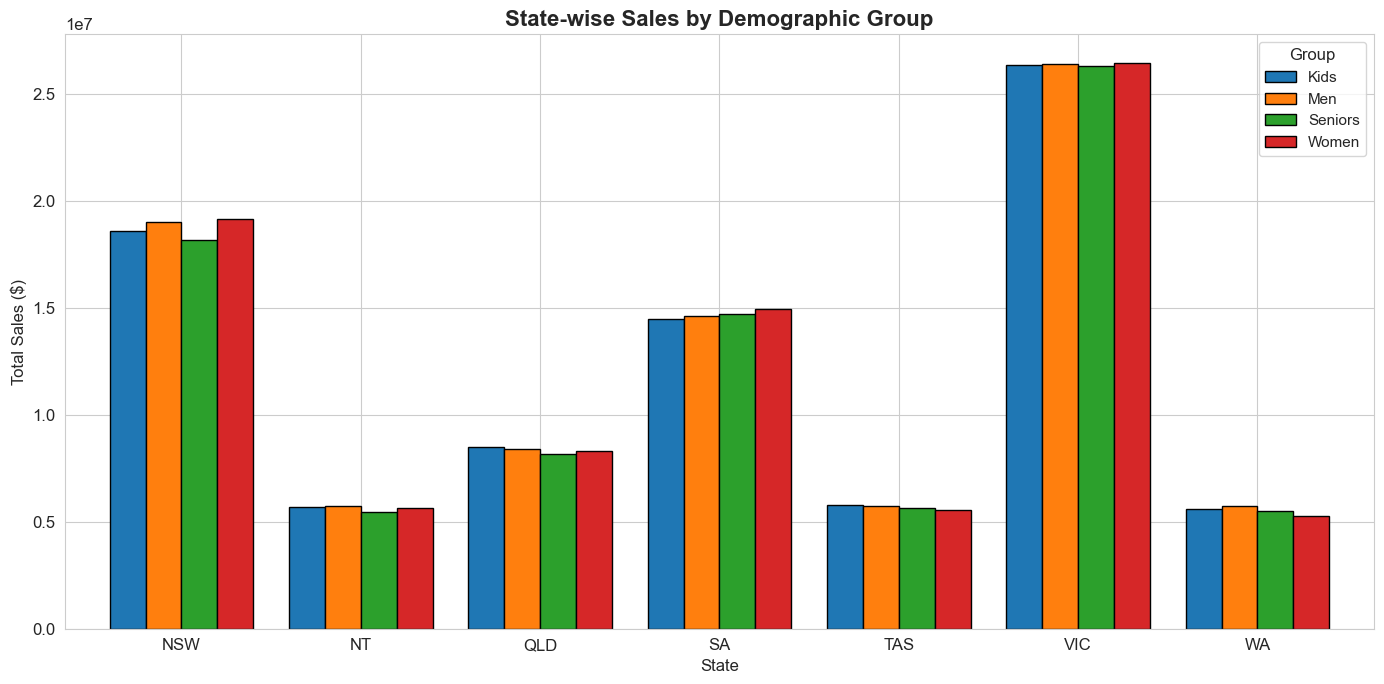

In [21]:
# State-wise sales for each demographic group
state_group_sales = df.groupby(['State', 'Group'])['Sales'].sum().unstack()

fig, ax = plt.subplots(figsize=(14, 7))
state_group_sales.plot(kind='bar', ax=ax, edgecolor='black', width=0.8)
ax.set_ylabel('Total Sales ($)', fontsize=12)
ax.set_xlabel('State', fontsize=12)
ax.set_title('State-wise Sales by Demographic Group', fontsize=16, fontweight='bold')
ax.legend(title='Group', fontsize=11, title_fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

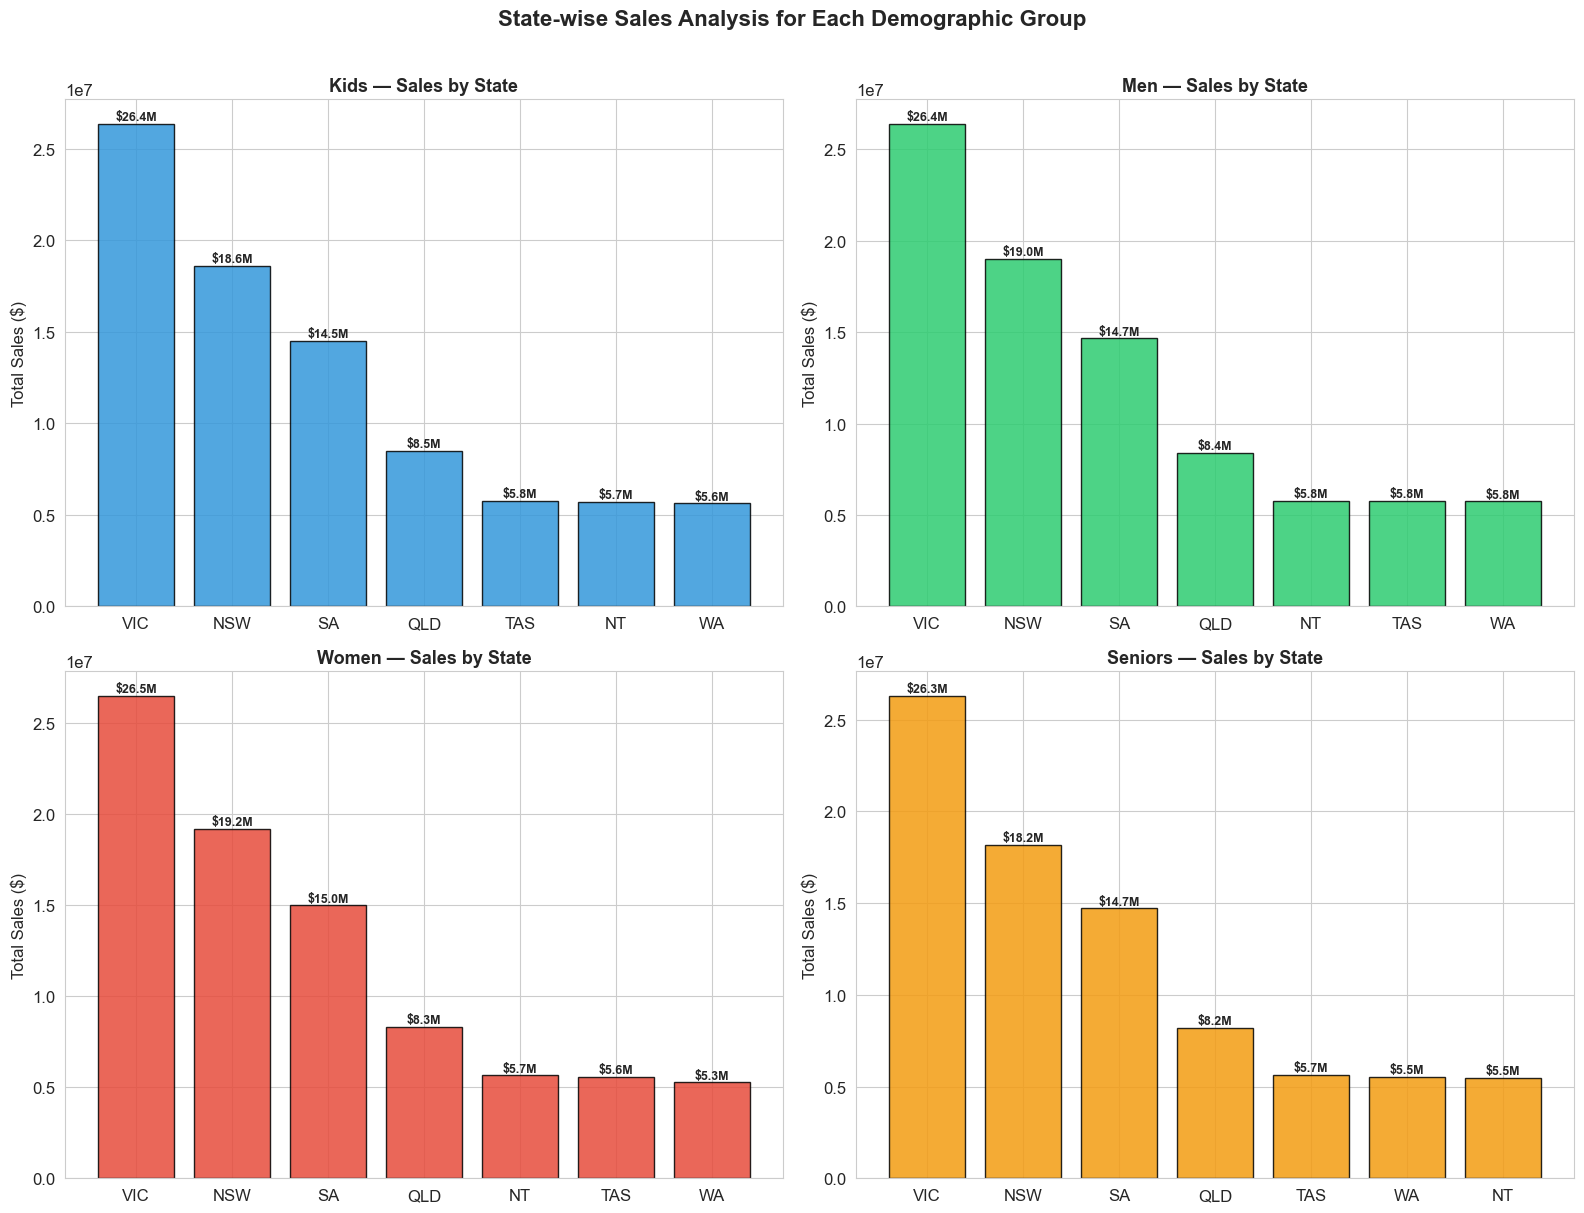

In [22]:
# Individual state-wise analysis for each group
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
groups = ['Kids', 'Men', 'Women', 'Seniors']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for ax, group, color in zip(axes.flatten(), groups, colors):
    data = df[df['Group'] == group].groupby('State')['Sales'].sum().sort_values(ascending=False)
    bars = ax.bar(data.index, data.values, color=color, edgecolor='black', alpha=0.85)
    ax.set_title(f'{group} — Sales by State', fontsize=13, fontweight='bold')
    ax.set_ylabel('Total Sales ($)')
    for bar, val in zip(bars, data.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200000,
                f'${val/1e6:.1f}M', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('State-wise Sales Analysis for Each Demographic Group', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 4.2 Group-wise Sales Analysis Across States

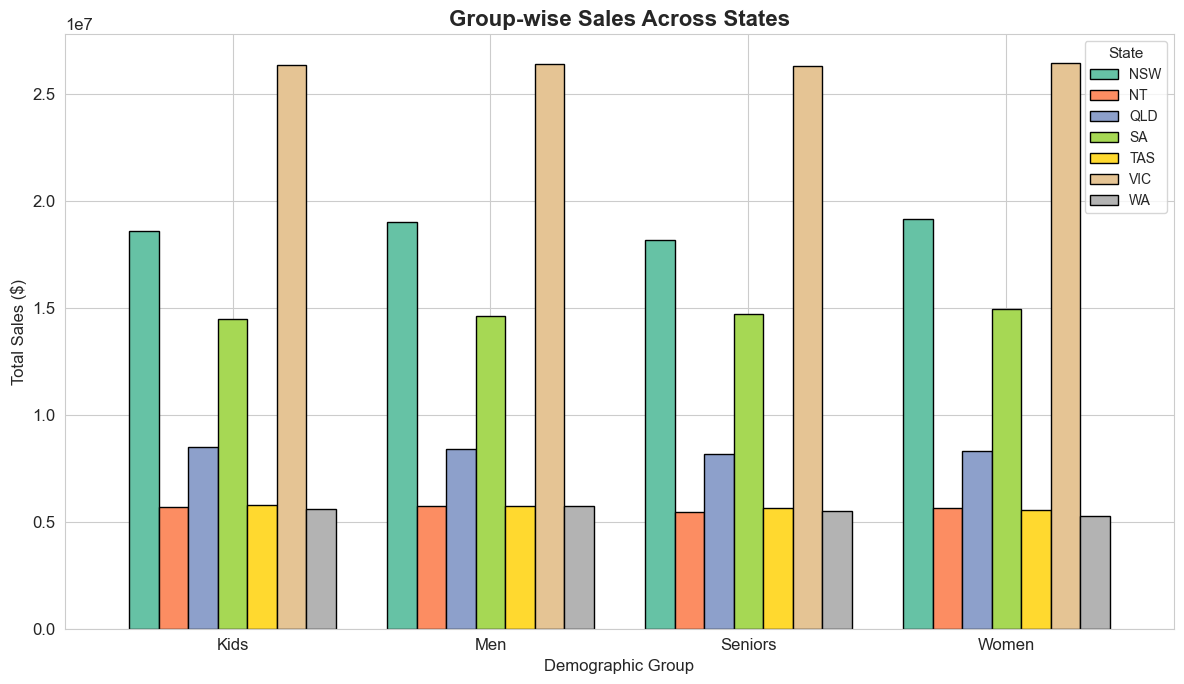

In [23]:
# Group-wise sales across states
group_state_sales = df.groupby(['Group', 'State'])['Sales'].sum().unstack()

fig, ax = plt.subplots(figsize=(12, 7))
group_state_sales.plot(kind='bar', ax=ax, edgecolor='black', width=0.8, colormap='Set2')
ax.set_ylabel('Total Sales ($)', fontsize=12)
ax.set_xlabel('Demographic Group', fontsize=12)
ax.set_title('Group-wise Sales Across States', fontsize=16, fontweight='bold')
ax.legend(title='State', fontsize=10, title_fontsize=11)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

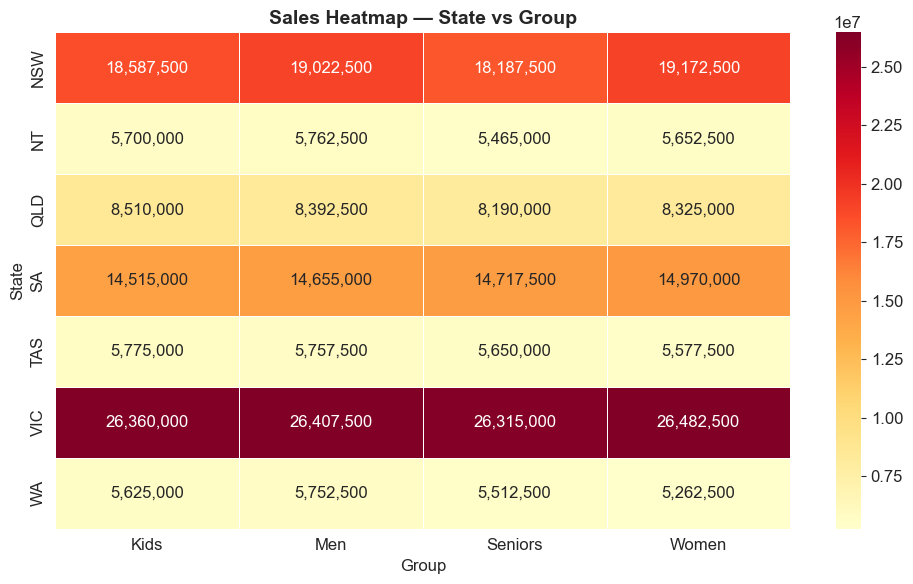

In [24]:
# Heatmap: State x Group
fig, ax = plt.subplots(figsize=(10, 6))
pivot = df.groupby(['State', 'Group'])['Sales'].sum().unstack()
sns.heatmap(pivot, annot=True, fmt=',.0f', cmap='YlOrRd', linewidths=0.5, ax=ax)
ax.set_title('Sales Heatmap — State vs Group', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.3 Time-of-Day Analysis — Peak & Off-Peak Sales

This analysis helps the S&M team identify optimal times for:
- **Hyper-personalization** campaigns
- **Next Best Offers** targeting
- Staff scheduling and inventory management

In [25]:
# Time-of-day analysis
time_sales = df.groupby('Time')['Sales'].agg(['sum', 'mean', 'count']).reset_index()
time_sales.columns = ['Time', 'Total_Sales', 'Avg_Sales', 'Transactions']

# Order: Morning, Afternoon, Evening
time_order = ['Morning', 'Afternoon', 'Evening']
time_sales['Time'] = pd.Categorical(time_sales['Time'], categories=time_order, ordered=True)
time_sales = time_sales.sort_values('Time')

print("Time-of-Day Sales Analysis:")
print(time_sales.to_string(index=False))

peak = time_sales.loc[time_sales['Total_Sales'].idxmax(), 'Time']
offpeak = time_sales.loc[time_sales['Total_Sales'].idxmin(), 'Time']
print(f"\n✓ Peak Sales Period:     {peak}")
print(f"✗ Off-Peak Sales Period: {offpeak}")

Time-of-Day Sales Analysis:
     Time  Total_Sales  Avg_Sales  Transactions
  Morning    114207500  45,320.44          2520
Afternoon    114007500  45,241.07          2520
  Evening    112087500  44,479.17          2520

✓ Peak Sales Period:     Morning
✗ Off-Peak Sales Period: Evening


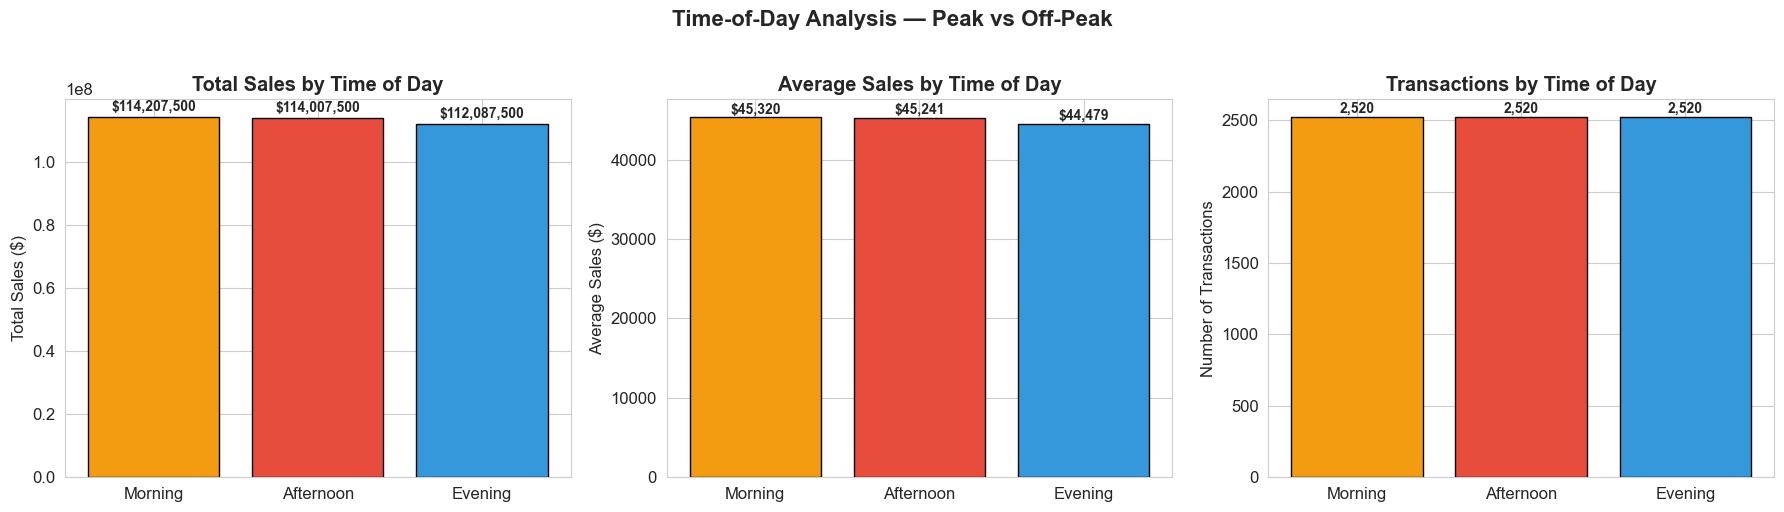

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total Sales by Time
colors_time = ['#f39c12', '#e74c3c', '#3498db']
axes[0].bar(time_sales['Time'], time_sales['Total_Sales'], color=colors_time, edgecolor='black')
for i, (_, row) in enumerate(time_sales.iterrows()):
    axes[0].text(i, row['Total_Sales'] + 2000000, f"${row['Total_Sales']:,.0f}",
                 ha='center', fontweight='bold', fontsize=10)
axes[0].set_ylabel('Total Sales ($)')
axes[0].set_title('Total Sales by Time of Day', fontweight='bold')

# Average Sales by Time
axes[1].bar(time_sales['Time'], time_sales['Avg_Sales'], color=colors_time, edgecolor='black')
for i, (_, row) in enumerate(time_sales.iterrows()):
    axes[1].text(i, row['Avg_Sales'] + 500, f"${row['Avg_Sales']:,.0f}",
                 ha='center', fontweight='bold', fontsize=10)
axes[1].set_ylabel('Average Sales ($)')
axes[1].set_title('Average Sales by Time of Day', fontweight='bold')

# Transaction count by Time
axes[2].bar(time_sales['Time'], time_sales['Transactions'], color=colors_time, edgecolor='black')
for i, (_, row) in enumerate(time_sales.iterrows()):
    axes[2].text(i, row['Transactions'] + 30, f"{row['Transactions']:,.0f}",
                 ha='center', fontweight='bold', fontsize=10)
axes[2].set_ylabel('Number of Transactions')
axes[2].set_title('Transactions by Time of Day', fontweight='bold')

plt.suptitle('Time-of-Day Analysis — Peak vs Off-Peak', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

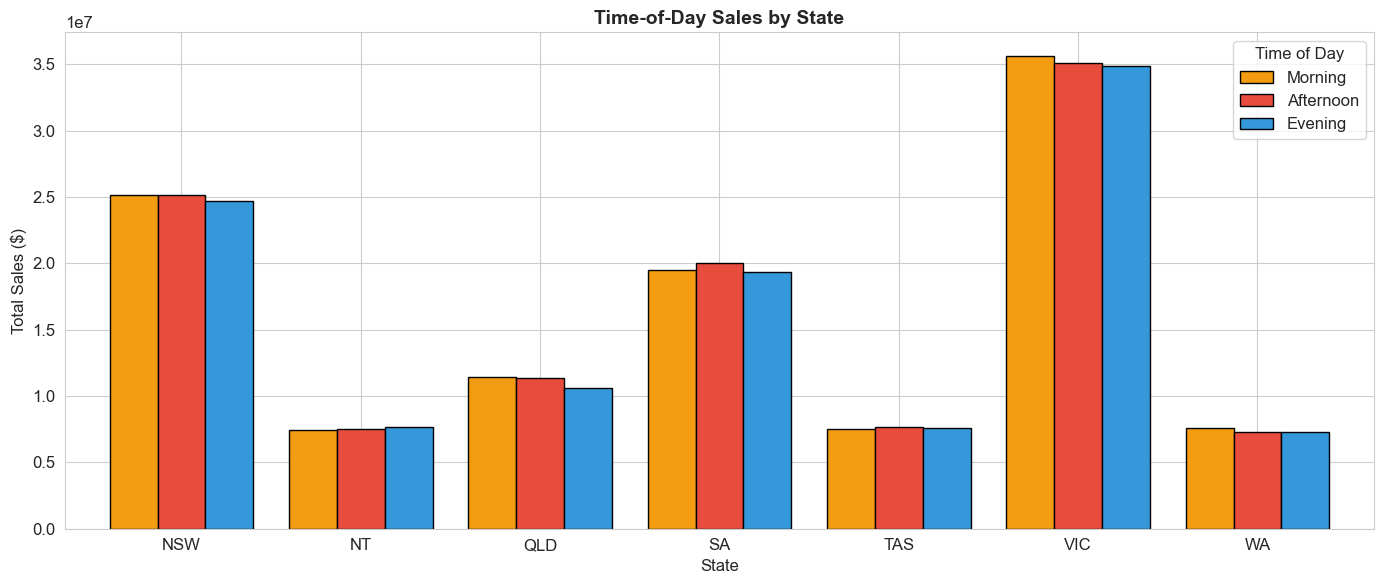

In [27]:
# Time-of-day breakdown by State
fig, ax = plt.subplots(figsize=(14, 6))
time_state = df.groupby(['State', 'Time'])['Sales'].sum().unstack()
time_state = time_state[time_order]
time_state.plot(kind='bar', ax=ax, color=colors_time, edgecolor='black', width=0.8)
ax.set_ylabel('Total Sales ($)')
ax.set_xlabel('State')
ax.set_title('Time-of-Day Sales by State', fontsize=14, fontweight='bold')
ax.legend(title='Time of Day')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

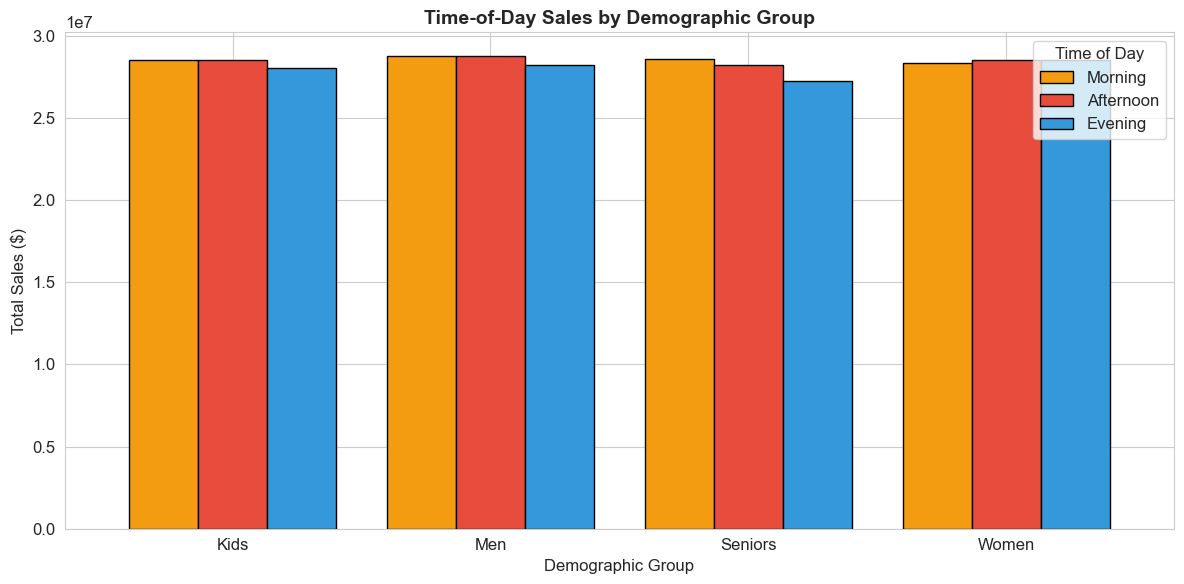

In [28]:
# Time-of-day breakdown by Group
fig, ax = plt.subplots(figsize=(12, 6))
time_group = df.groupby(['Group', 'Time'])['Sales'].sum().unstack()
time_group = time_group[time_order]
time_group.plot(kind='bar', ax=ax, color=colors_time, edgecolor='black', width=0.8)
ax.set_ylabel('Total Sales ($)')
ax.set_xlabel('Demographic Group')
ax.set_title('Time-of-Day Sales by Demographic Group', fontsize=14, fontweight='bold')
ax.legend(title='Time of Day')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 4.4 Daily Sales Chart

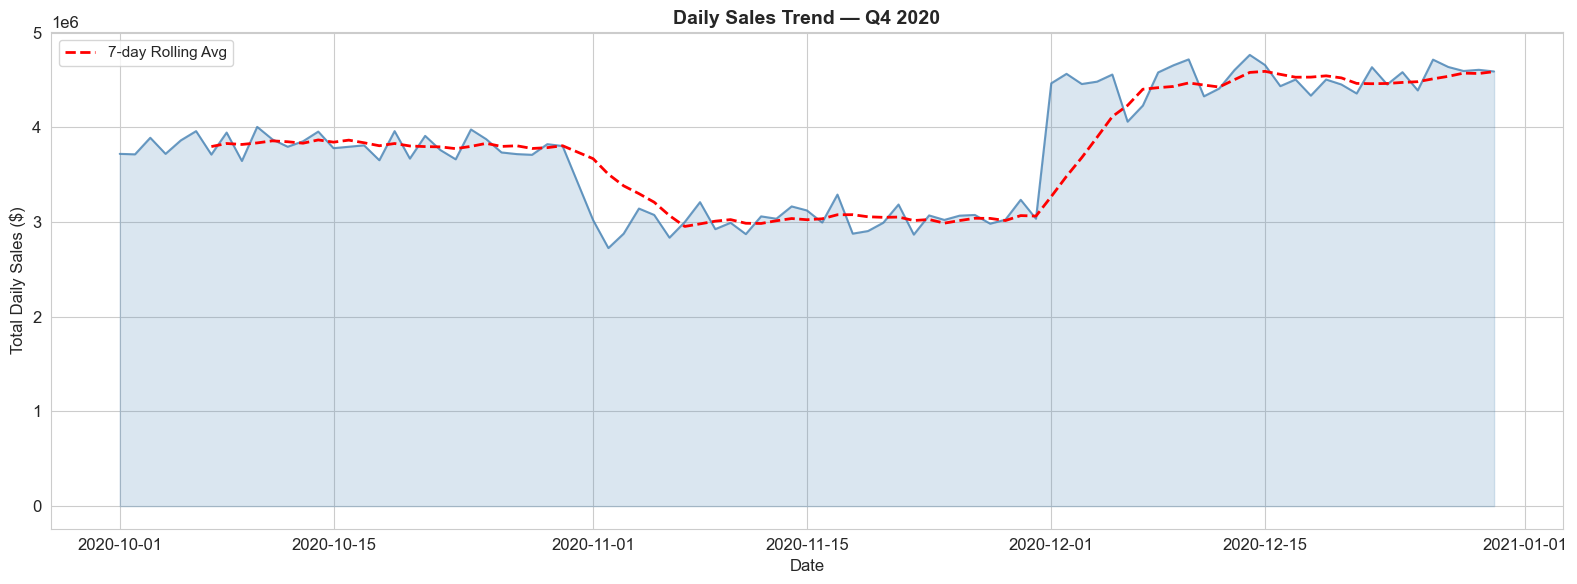

In [29]:
daily_sales = df.groupby('Date')['Sales'].sum().reset_index()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(daily_sales['Date'], daily_sales['Sales'], color='steelblue', linewidth=1.5, alpha=0.8)
ax.fill_between(daily_sales['Date'], daily_sales['Sales'], alpha=0.2, color='steelblue')

# Add rolling average
rolling_avg = daily_sales['Sales'].rolling(window=7).mean()
ax.plot(daily_sales['Date'], rolling_avg, color='red', linewidth=2, linestyle='--', label='7-day Rolling Avg')

ax.set_xlabel('Date')
ax.set_ylabel('Total Daily Sales ($)')
ax.set_title('Daily Sales Trend — Q4 2020', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

### 4.5 Weekly Sales Chart

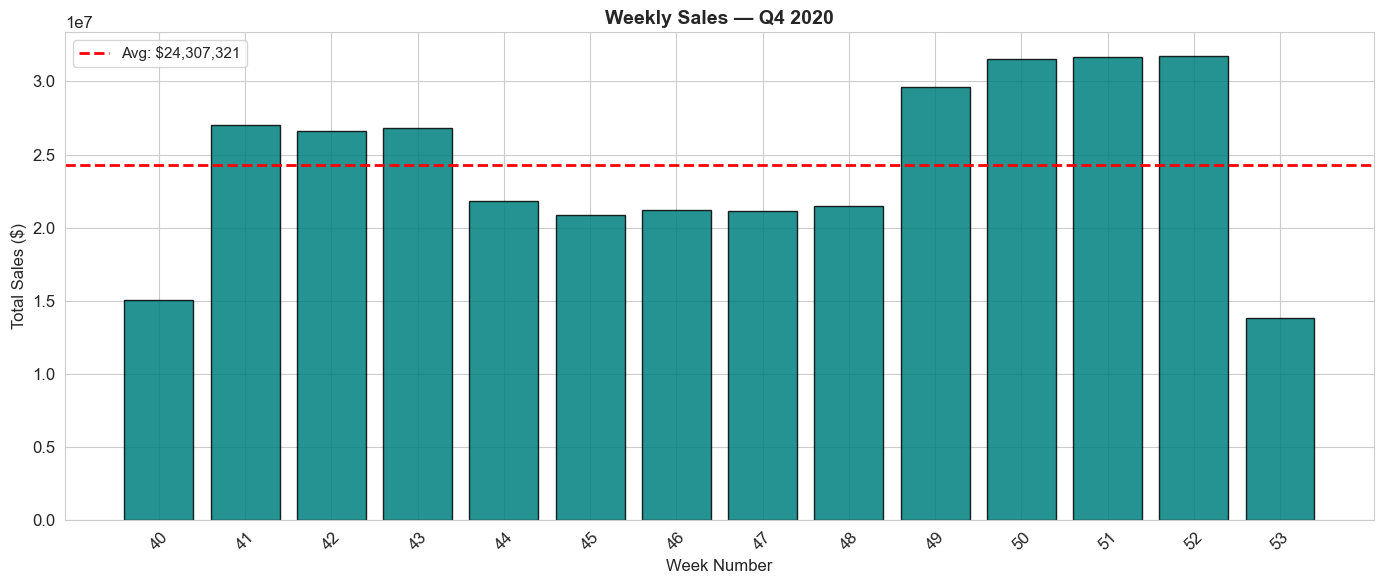

In [30]:
weekly_sales = df.groupby('Week')['Sales'].sum().reset_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(weekly_sales['Week'].astype(str), weekly_sales['Sales'], color='teal', edgecolor='black', alpha=0.85)
ax.axhline(y=weekly_sales['Sales'].mean(), color='red', linestyle='--', linewidth=2,
           label=f"Avg: ${weekly_sales['Sales'].mean():,.0f}")
ax.set_xlabel('Week Number')
ax.set_ylabel('Total Sales ($)')
ax.set_title('Weekly Sales — Q4 2020', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.6 Monthly Sales Chart

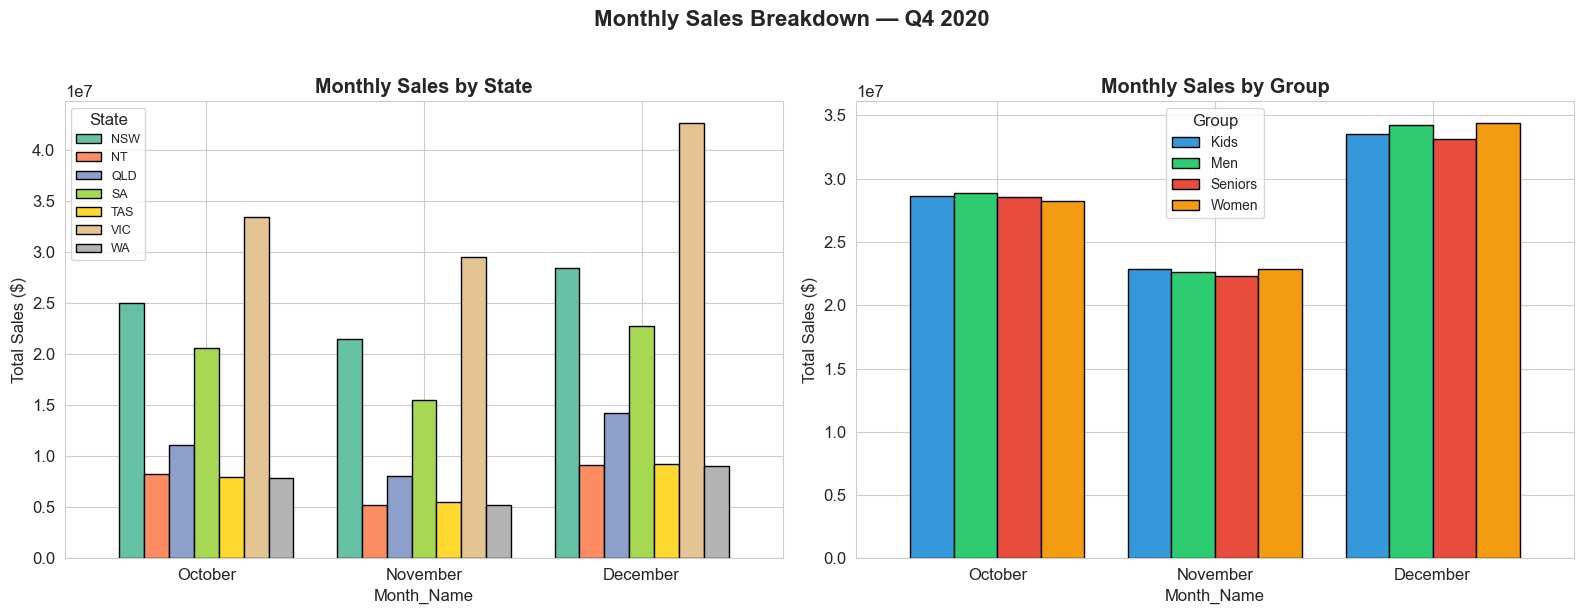

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Monthly sales by State
monthly_state = df.groupby(['Month_Name', 'State'])['Sales'].sum().unstack()
monthly_state = monthly_state.reindex(['October', 'November', 'December'])
monthly_state.plot(kind='bar', ax=axes[0], edgecolor='black', width=0.8, colormap='Set2')
axes[0].set_ylabel('Total Sales ($)')
axes[0].set_title('Monthly Sales by State', fontweight='bold')
axes[0].legend(title='State', fontsize=9)
axes[0].tick_params(axis='x', rotation=0)

# Monthly sales by Group
monthly_group = df.groupby(['Month_Name', 'Group'])['Sales'].sum().unstack()
monthly_group = monthly_group.reindex(['October', 'November', 'December'])
monthly_group.plot(kind='bar', ax=axes[1], edgecolor='black', width=0.8,
                   color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[1].set_ylabel('Total Sales ($)')
axes[1].set_title('Monthly Sales by Group', fontweight='bold')
axes[1].legend(title='Group', fontsize=10)
axes[1].tick_params(axis='x', rotation=0)

plt.suptitle('Monthly Sales Breakdown — Q4 2020', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 4.7 Quarterly Summary Chart

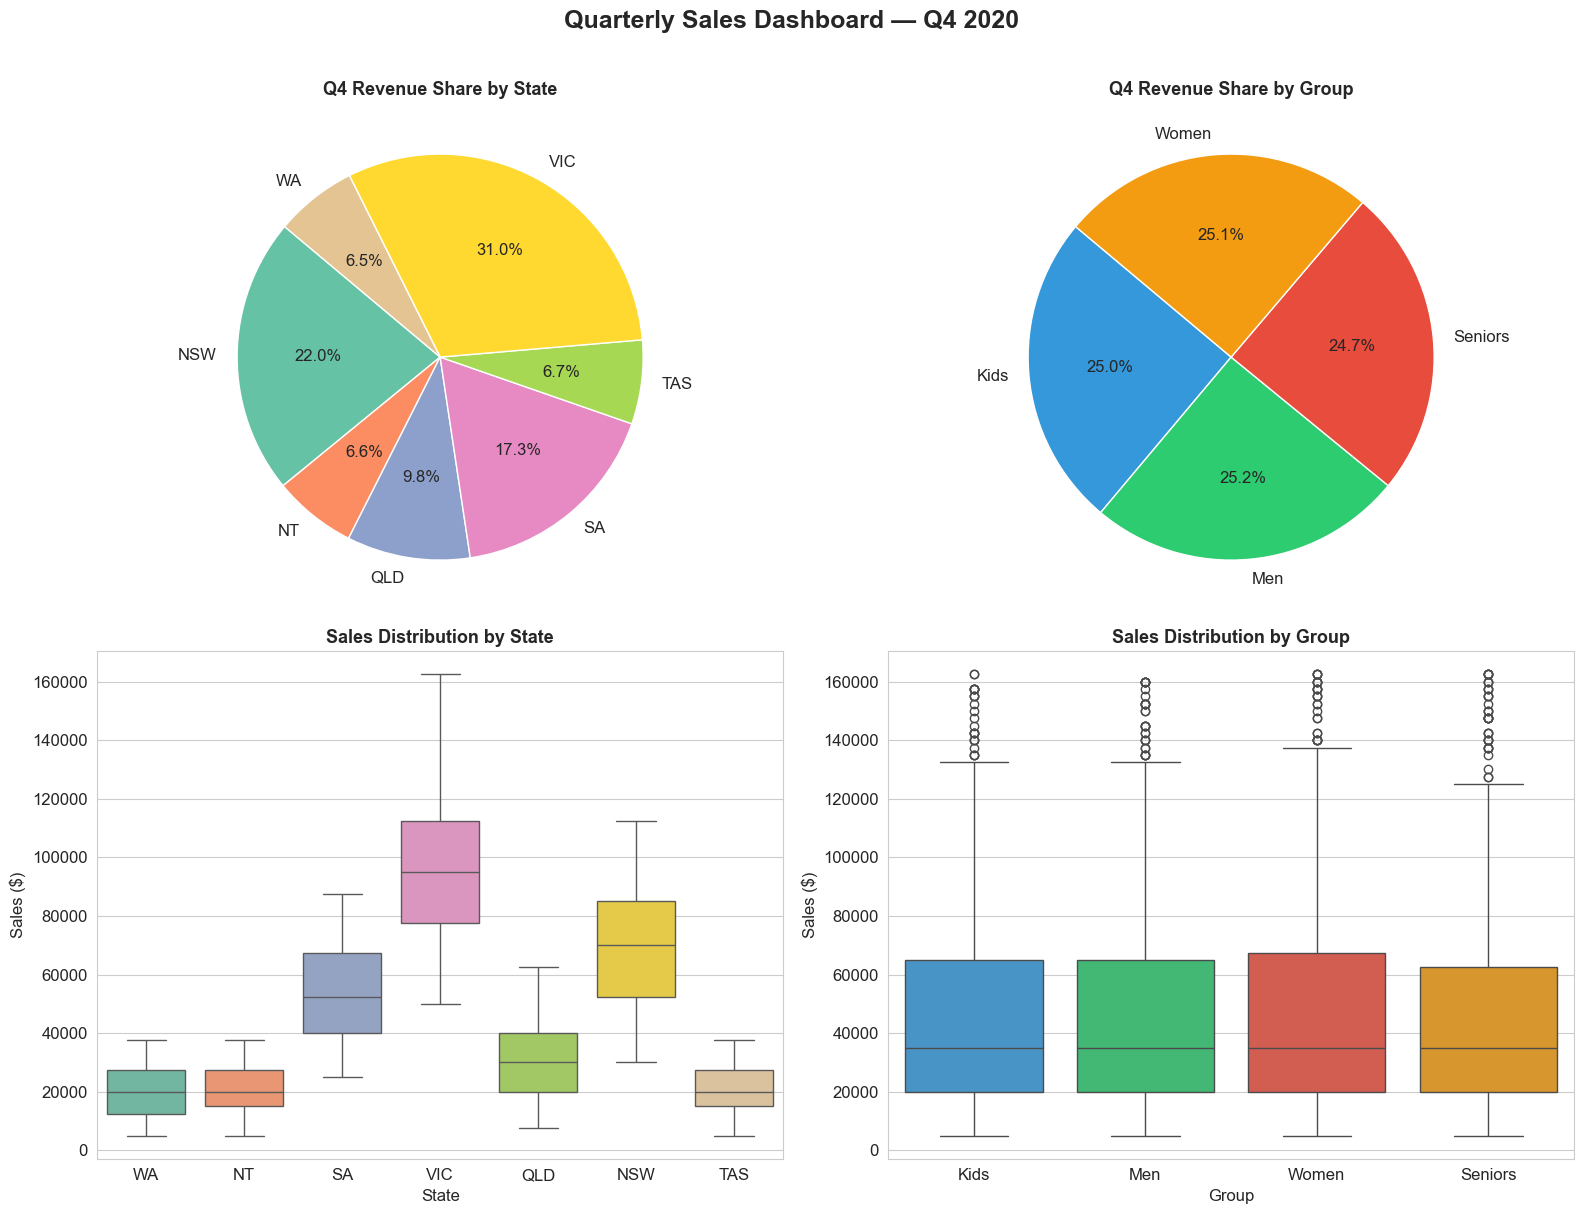

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. State-wise total Q4 sales (pie)
state_total = df.groupby('State')['Sales'].sum()
axes[0, 0].pie(state_total, labels=state_total.index, autopct='%1.1f%%',
               startangle=140, colors=sns.color_palette('Set2', len(state_total)))
axes[0, 0].set_title('Q4 Revenue Share by State', fontweight='bold', fontsize=13)

# 2. Group-wise total Q4 sales (pie)
group_total = df.groupby('Group')['Sales'].sum()
axes[0, 1].pie(group_total, labels=group_total.index, autopct='%1.1f%%',
               startangle=140, colors=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[0, 1].set_title('Q4 Revenue Share by Group', fontweight='bold', fontsize=13)

# 3. Box plot: Sales distribution by State
sns.boxplot(x='State', y='Sales', data=df, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Sales Distribution by State', fontweight='bold', fontsize=13)
axes[1, 0].set_ylabel('Sales ($)')

# 4. Box plot: Sales distribution by Group
sns.boxplot(x='Group', y='Sales', data=df, ax=axes[1, 1],
            palette=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[1, 1].set_title('Sales Distribution by Group', fontweight='bold', fontsize=13)
axes[1, 1].set_ylabel('Sales ($)')

plt.suptitle('Quarterly Sales Dashboard — Q4 2020', fontsize=18, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 5. Recommendations & Insights

### 5.1 Key Findings

**State-wise Revenue Analysis:**
- States with the highest revenue should continue to receive investment in inventory and marketing
- Lower-revenue states represent growth opportunities — targeted campaigns and promotions can help boost sales

**Demographic Group Insights:**
- The top-performing group drives the most revenue and should be the focus of retention strategies
- The lowest-performing group needs targeted acquisition campaigns and product line adjustments

**Time-of-Day Insights:**
- Peak sales periods should be leveraged for **hyper-personalization** — push notifications, flash sales, and targeted offers during high-traffic hours
- Off-peak periods present opportunities for **Next Best Offers** — discounts and promotions to drive traffic during slower hours
- Staff scheduling should align with peak periods for optimal customer service

### 5.2 Sales Program Recommendations for Low-Revenue States

1. **Localized Marketing Campaigns:** Design state-specific promotions considering local preferences, festivals, and seasonal trends
2. **Product Mix Optimization:** Analyze which demographic groups underperform in low-revenue states and adjust the product assortment accordingly
3. **Digital Marketing Push:** Increase online advertising spend in underperforming states to build brand awareness
4. **Loyalty Programs:** Introduce state-specific loyalty rewards to increase repeat purchases
5. **Store Experience Enhancement:** Invest in store layout, staff training, and in-store events in low-performing locations
6. **Time-based Promotions:** Use off-peak hours for special discounts to drive additional foot traffic

### 5.3 Data-Driven Decision Framework

For the upcoming year, AAL should:
- **Invest heavily** in top-revenue states to maintain market dominance
- **Allocate growth budgets** to low-revenue states with targeted programs
- **Optimize staffing** based on time-of-day sales patterns
- **Tailor product offerings** by demographic group performance per state
- **Monitor weekly trends** to quickly identify and respond to sales fluctuations